<a href="https://colab.research.google.com/github/ernestoespo33/tirocinio/blob/main/U_Net_COL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentazione d'immagini
Il presente notebook si prefigge il compito di riconoscere i soggetti in un insieme d'immagini, al fine di esplorare il funzionamento delle reti neurali. Tale compito verrà svolto tramite l'uso di TensorFlow, una piattaforma open source che mette a disposizione librerie, modelli e risorse per sviluppare e addestrare modelli Machine Learning. Questo tipo di programmazione si differenzia da quella standard perché dà al computer una serie d'informazioni, soluzioni e dati, in modo che sia esso stesso a creare le proprie regole per individuare la soluzione giusta tra quelle sbagliate.

Quando il soggetto dell'immagine non è l'unico al suo interno, è possibile usare la segmentazione per riconoscerne la posizione, o meglio quali sono i pixel che lo compongono. In particolare, a ogni pixel viene associata un'etichetta, in modo da distinguere il soggetto, il suo contorno e lo sfondo, così da produrre una maschera e comprendere l'immagine a livello pixel. 

Il riconoscimento delle mammelle bovine verrà fatta a partire da un dataset contenente cani e gatti, per addestrare la rete a riconoscere forme animali. In particolare si vuole costruire una rete atta alla segmentazione delle immagini, ovvero il riconoscimento di posizione e forma dell'animale stesso, a partire dai pixel. Successivamente verranno usati i pesi migliori, con un secondo notebook, sulle immagini d'interesse. 

In [ ]:
#Pip è un tool atto a installare pacchetti
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\saran\appdata\local\temp\pip-req-build-h5vsd9j8


  Running command git clone -q https://github.com/tensorflow/examples.git 'C:\Users\saran\AppData\Local\Temp\pip-req-build-h5vsd9j8'


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from tensorflow import keras
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Le immagini che vengono passate in questa funzione sono array NumPy 128x128, con valori di pixel compresi tra 0 e 255. Esse vengono scalate su un intervallo da 0 a 1 prima di essere inserite nel modello. Successivamente si procede a modificare la maschera del training set. Infatti, mentre i pixel nella maschera di segmentazione sono etichettati con {1, 2, 3}, per comodità si sottrae 1 dalla maschera di segmentazione, ottenendo etichette che sono: {0, 1, 2}.

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

La seguente funzione ridimensiona le immagini, le rispettive maschere ed esegue un augmentation, capovolgendo orizzontalmente alcune immagini random. Essa viene usata con un decoratore, ovvero estende il comportamento di fn.function, che crea grafici.


In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    

    
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask



In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    

    
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Un'epoca è il tempo che impiega la rete per processare l'intero dataset. Esso viene diviso in sottoinsiemi, batch, la cui grandezza è il batch size. Ad ogni epoca tutti i sottoinsiemi vengono processati, uno per ogni step.

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Il set di dati contiene già le suddivisioni richieste di test e training, che vengono mantenute e caricate in due dataset differenti e map() applica le funzioni sopra descritte. Poiché gli elementi di input sono indipendenti l'uno dall'altro, la pre-elaborazione può essere parallelizzata su più core della CPU, riducendo il tempo complessivo per una singola iterazione. Per rendere ciò possibile la trasformazione map fornisce l'argomento num_parallel_calls per specificare il livello di parallelismo. In tal caso è stato scelto con AUTOTUNE di delegare la decisione al runtime tf.data.

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

Il dataset train finale avrà i dati precaricati nella cache, in pacchetti di dimensioni pari alla batch size scelta, e sempre rimescolati. Ciò viene ripetuto infinite volte, mai terminando senza dati. Il metodo prefetch serve a preparare gli elementi mentre quelli correnti vengono processati, al fine di velocizzare le operazioni, usando memoria aggiuntiva.

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Carica dal training set la prima immagine dell'insieme e la relativa maschera e le plotta.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

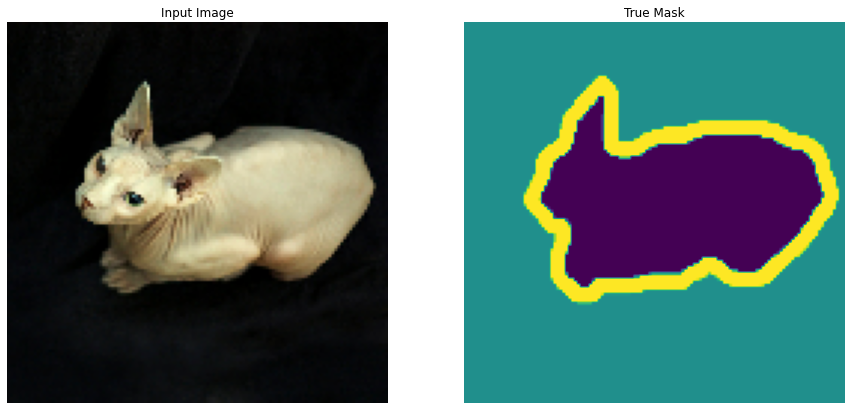

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

Si vogliono salvare all'interno di un file i pesi del modello migliore, valutato secondo l'accuracy.

In [ ]:
checkpoint_filepath = "training_COL/cp.ckpt"

checkpoint_dir = os.path.dirname(checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Modello U-Net modificato
La U-Net è una rete neurale convoluzionale nata per la segmentazione delle immagini biomediche. Essa è composta da una prima parte atta a comprimere l'immagine e una seconda con il compito di espanderla. La prima è una tipica rete neurale convoluzionale che consiste nella ripetuta applicazione di convoluzioni, funzioni d'attivazione e MaxPooling. Durante la contrazione viene ridotta la dimensione e aumentato l'insieme delle informazioni, ovvero viene ridotto il "dove" e aumentato il "cosa". La seconda parte ha il compito di espandere e combinare le caratteristiche per ottenere un'immagine di dimensioni pari a quella originale. Le due parti sono strutturate in modo che risultino simmetriche tra loro. Per prima cosa è necessario indicare il numero di canali, uno per ogni etichetta. Si può pensare a ciò come se fosse una classificazione multipla in cui ogni pixel viene attribuito a una di 3 classi, relative al soggetto, al suo contorno e allo sfondo.

In [ ]:
OUTPUT_CHANNELS = 3

Al fine di costruire la U-Net, è necessario quindi usare in primo luogo un modello con il ruolo di encoder, possibilmente pre-addestrato, per ridurre il numero di parametri addestrabili. A questo scopo si usa il modello MobileNetV2, del quale verranno usati solo dei livelli intermedi. In particolare verranno estratti principalmente i livelli Conv2D, con funzione di attivazione ReLu, e i rispettivi MaxPooling, per dimezzare ogni volta la dimensione dell'immagine. Come si vedrà successivamente, sono i Conv2D che dovranno essere concatenati con i rispettivi Conv2DTranspose appartenenti all'upsample del decoder, per mantenere la corrispondenza tra i due.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

Come decodificatore si usa il modello Pix2Pix, composto da una serie di blocchi di sovracampionamento. In particolare ognuno di questi è composto da funzioni di attivazione ReLu e da livelli Conv2DTranspose, che, tramite filtri e ponendo strides=2, raddoppiano le dimensioni dell'immagine di input.

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Si crea così il modello U-Net dalla concatenazione dei livelli di encoder e decoder. I livelli devono essere concatenati per recuperare le informazioni spaziali perse durante la contrazione delle immagini, causata dall'encoder. In particolare vengono concatenate le dimensioni dei tensori, gli assi, e si cicla fino a quando tutti i livelli di Conv2D e Conv2DTranspose corrispondenti non sono concatenati.

"The Importance of Skip Connections in Biomedical Image Segmentation Michal" Drozdzal, Eugene Vorontsov, Gabriel Chartrand, Samuel Kadoury, and Chris Pal https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    
  
  skips = down_stack(inputs)
  
  x = skips[-1]
  
  skips = reversed(skips[:-1])

  
    
  
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Ulteriori impostazioni che precedono l'addestramento del modello, vengono fornite in fase di compilazione. L'ottimizzatore è una classe tramite la quale il modello viene aggiornato in base ai dati visualizzati e alla sua funzione di perdita. In tal caso viene scelto Adam, che è un metodo a discesa stocastica del gradiente. In sostanza viene considerata una funzione e ne vengono determinati i punti di minimo tramite il gradiente, di cui però viene considerata solo una stima. Quest'ultima è valutata, ad ogni iterazione, su un sottoinsieme di elementi del dataset, pari al batch size, che se troppo grande va a ridurre l'accuratezza, ovvero la frazione delle immagini classificate correttamente. La funzione di perdita misura l'accuratezza del modello durante l'addestramento. Si desidera ridurre al minimo questa funzione per "guidare" il modello nella giusta direzione. Le metriche vengono utilizzate per monitorare le fasi di addestramento e test.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
      print(image.shape,type(image))
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

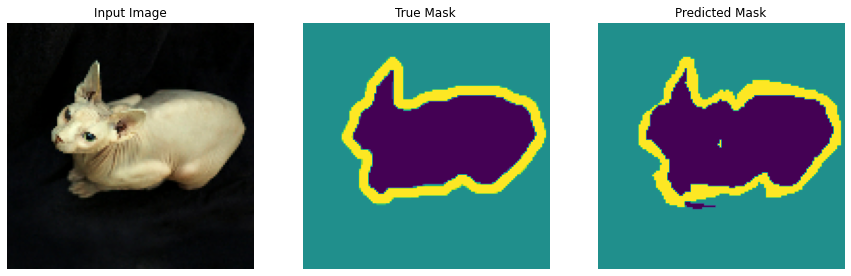


Sample Prediction after epoch 50

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(),model_checkpoint_callback])

!mkdir -p saved_model
model.save('saved_model_COL/my_model')

In [ ]:
%ls {checkpoint_dir}

 Il volume nell'unità C non ha etichetta.
 Numero di serie del volume: C4CD-61AD

 Directory di C:\Users\saran\Notebook Jupyter\training_1

28/03/2021  20:05    <DIR>          .
28/03/2021  20:05    <DIR>          ..
28/03/2021  20:46    <DIR>          cp.ckpt
               0 File              0 byte
               3 Directory  265.003.151.360 byte disponibili


In [ ]:
%ls saved_model

%ls saved_model/my_model

 Il volume nell'unità C non ha etichetta.
 Numero di serie del volume: C4CD-61AD

 Directory di C:\Users\saran\Notebook Jupyter\saved_model

28/03/2021  22:02    <DIR>          .
28/03/2021  22:02    <DIR>          ..
28/03/2021  22:02    <DIR>          my_model
               0 File              0 byte
               3 Directory  265.003.151.360 byte disponibili


Opzione non valida - "my_model".


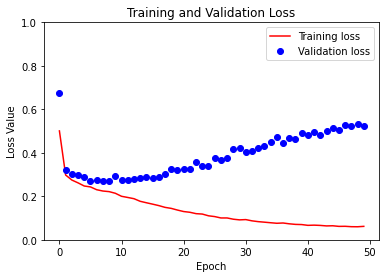

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print("\nTrained model")
print('Test accuracy:{:5.2f}%'.format(100 * test_acc))

new_model = keras.models.load_model(checkpoint_filepath)

score = new_model.evaluate(test_dataset, verbose=0)
print("\nBest performance")
print("Test loss:{:5.2f}".format(score[0]))
print("Test accuracy:{:5.2f}%".format(100 * score[1]))

58/58 - 56s - loss: 0.5288 - accuracy: 0.8840

Trained model
Test accuracy:88.40%

Best performance
Test loss: 0.29
Test accuracy:89.29%
